In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [25]:
from differential_model import *
from generate_data import *
from physical_model import *

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")


No GPU available, using CPU.


In [27]:
# System parameters
m = 1.0  # mass
c = 0.2  # damping coefficient
k = 100.0  # spring constant

# Time
t0 = 0
tf = 10

# Frequncy
fs = 50

# tspan
tspan = torch.arange(t0, tf, 1/fs)
nt = tf * fs

In [28]:
# Initialize the Spring_Model on the GPU
spring_model_gt = Spring_Model(m, c, k, t0, tf, fs, device, [10000, 3, 0, 2, 0])
simulator = Linear_Spring_Model(m, c, k, t0, tf, fs, device)

In [29]:
sig_u = [0.25, 0.5, 0.75, 1, 1.25]
data_gt = torch.zeros(nt, len(sig_u), 2)
data_simulated = torch.zeros(nt, len(sig_u), 2)
u_data = torch.zeros(nt, len(sig_u))

for i in range(len(sig_u)):
    u = generate_u(sig_u[i], nt, fs, device)
    data_gt[:, i, :] = generate_date(spring_model_gt, u).T
    data_simulated[:, i, :] = generate_date(simulator, u).T
    u_data[:, i] = u


In [30]:
initial_error = torch.mean((data_gt -data_simulated) ** 2)
initial_error

tensor(0.0083)

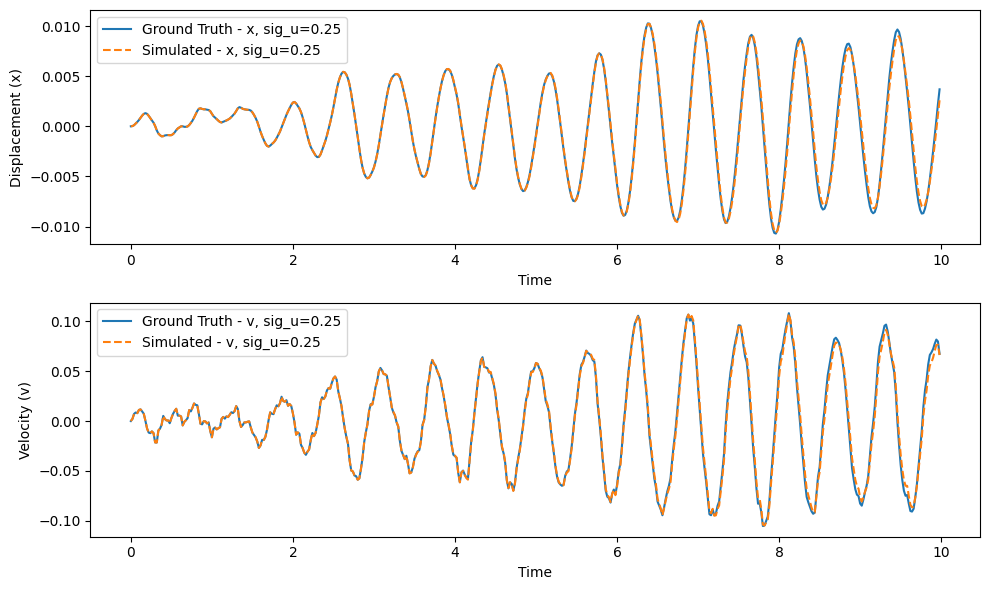

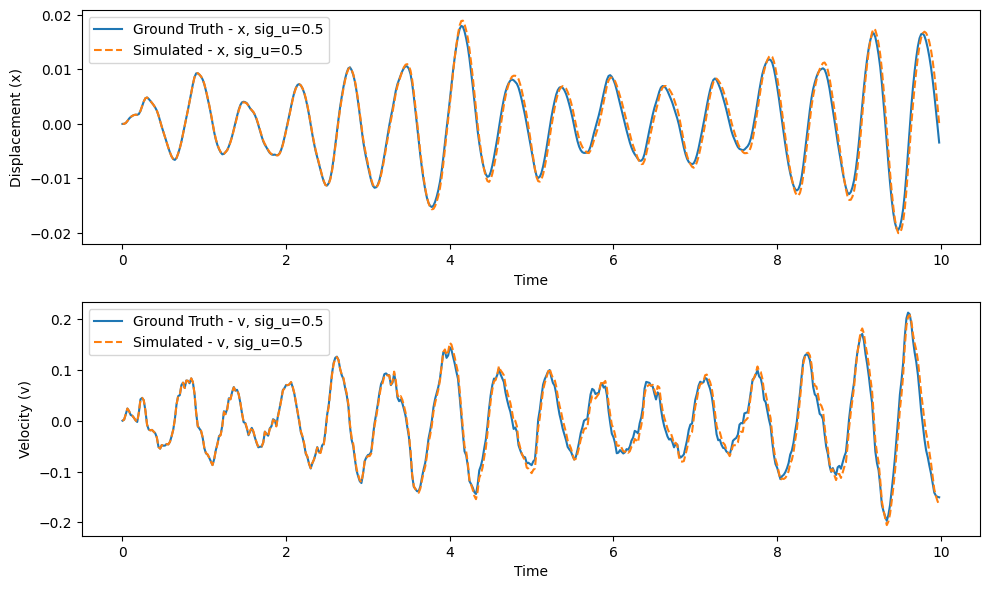

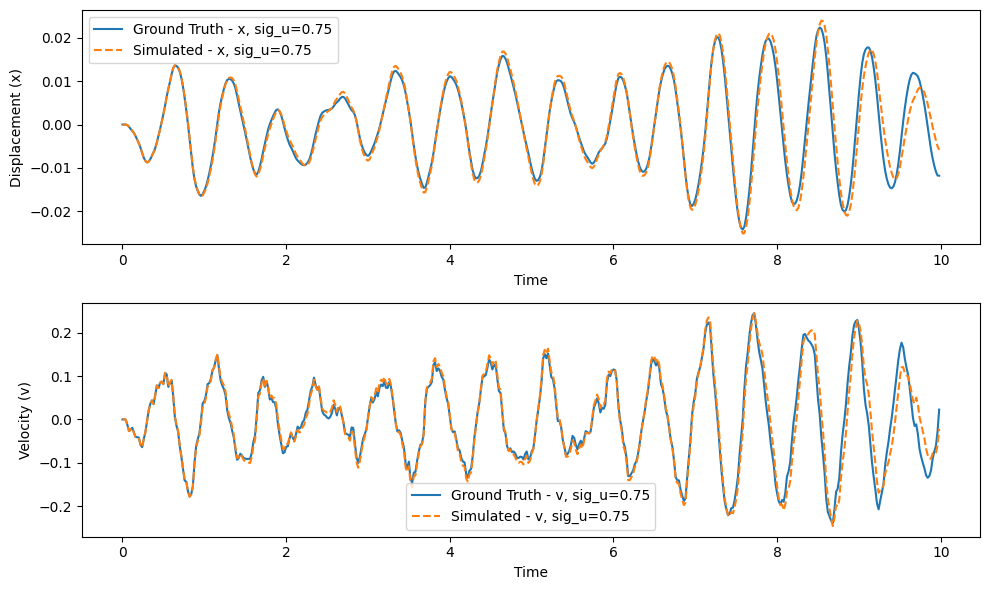

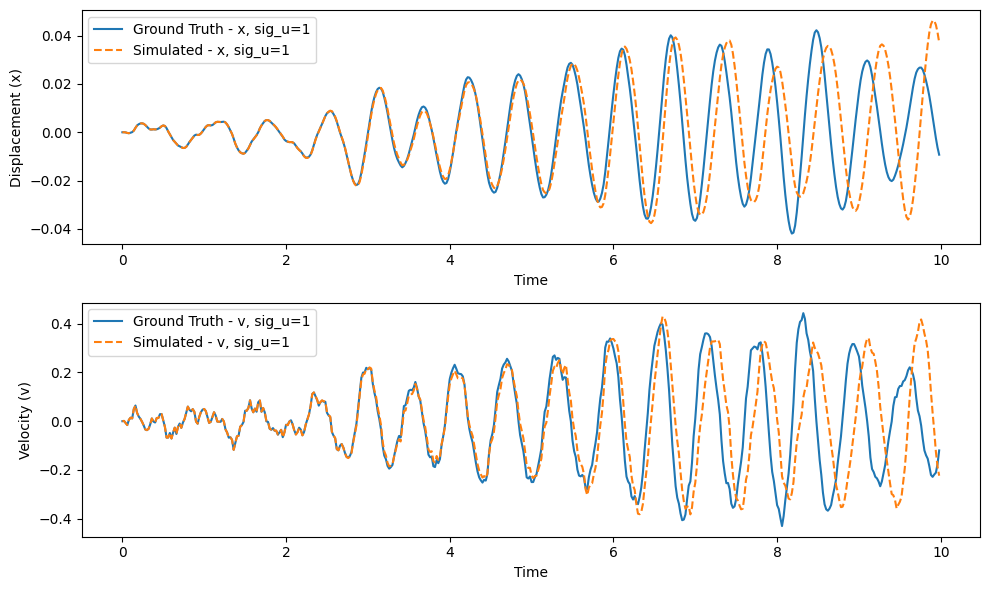

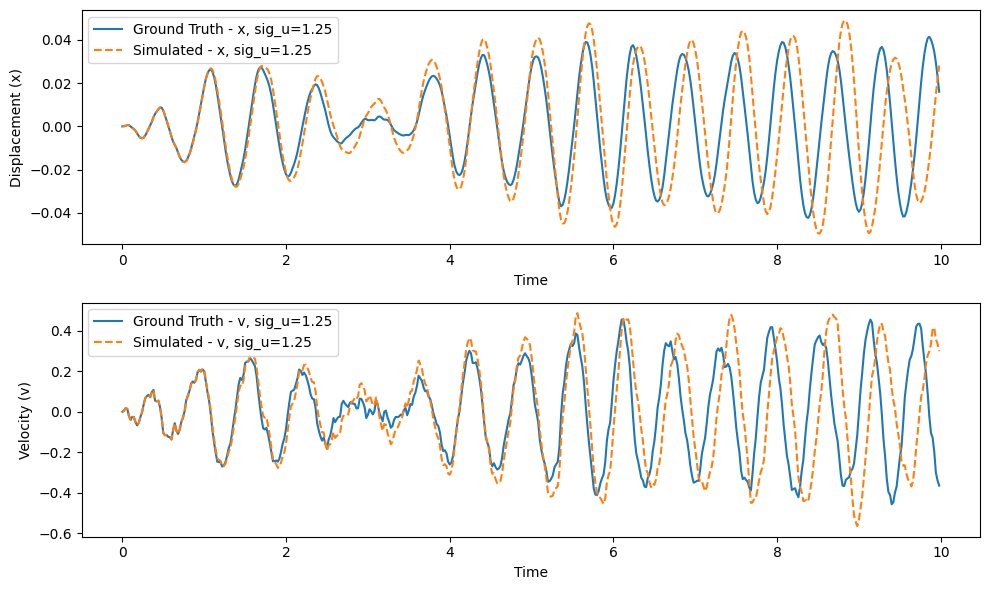

In [31]:
# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u)):
    plt.figure(figsize=(10, 6))

    # Plotting Ground Truth and Simulated Data for 'x'
    plt.subplot(2, 1, 1)
    plt.plot(time_values, data_gt[:, i, 0], label=f'Ground Truth - x, sig_u={sig_u[i]}')
    plt.plot(time_values, data_simulated[:, i, 0], label=f'Simulated - x, sig_u={sig_u[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.legend()

    # Plotting Ground Truth and Simulated Data for 'v'
    plt.subplot(2, 1, 2)
    plt.plot(time_values, data_gt[:, i, 1], label=f'Ground Truth - v, sig_u={sig_u[i]}')
    plt.plot(time_values, data_simulated[:, i, 1], label=f'Simulated - v, sig_u={sig_u[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [32]:
class DifferentialSolver:
    def __init__(self, model, optimizer, criterion=nn.MSELoss()):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, simulation, target_solution, u, max_epochs=100, msteps=2, batch_size=1000):
        if max_epochs > 100000:
            display_at = 5000
        elif max_epochs > 10000:
            display_at = 2000
        else:
            display_at = max(1, max_epochs / 100)
        losses = []
        N = target_solution.shape[0]
        feasible_range = N - msteps - 1
        std_data = torch.std(target_solution, axis = 0).T    #torch.Size([2, 5])

        for sim in range(max_epochs):
            self.optimizer.zero_grad()
            loss = 0

            for batch in range(batch_size):
                r = np.random.randint(feasible_range)
                yi = target_solution[r, :].T # torch.Size([2, 5])

                for m in range(msteps):
                    u_m = u[r + m: r + m + 1, :] # torch.Size([1, 5])
                    yi = simulation.step(yi, u_m)
                    input = torch.cat([u_m, yi], axis=0).T  # Concatenate k and yi.T
                    dy_i = self.model(input).T # torch.Size([2, 5])
                    yi = yi + dy_i
                    loss += self.criterion(yi.div(std_data) , target_solution[r + m + 1, :].T.div(std_data)) / msteps

            loss /= batch_size
            loss.backward(retain_graph=True)
            self.optimizer.step()
            losses.append(loss.item())

            if sim % display_at == 0:
                print(sim, "Training Loss:", loss.item())

        return losses

In [33]:
# Create a neural network model
model = NeuralNet(3, [16, 32, 64, 32, 16], 2, nn.ReLU(), device)

# Create a DifferentialSolver and train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
solver = DifferentialSolver(model, optimizer)

In [34]:
losses = solver.train(simulator, target_solution=data_gt, u = u_data, max_epochs=200000, msteps=3, batch_size=1)

0 Training Loss: 56.43415069580078
5000 Training Loss: 0.0009270879672840238
10000 Training Loss: 0.0004629609175026417
15000 Training Loss: 0.00011425712000345811
20000 Training Loss: 5.327727194526233e-05
25000 Training Loss: 2.8848378860857338e-05
30000 Training Loss: 1.4270788597059436e-05
35000 Training Loss: 6.596802995773032e-05
40000 Training Loss: 0.0007505007088184357
45000 Training Loss: 9.111137478612363e-05
50000 Training Loss: 5.8004105085274205e-05
55000 Training Loss: 0.00027798116207122803
60000 Training Loss: 2.4090695660561323e-05
65000 Training Loss: 1.0403195119579323e-05
70000 Training Loss: 3.461739106569439e-05
75000 Training Loss: 0.00010563550313236192
80000 Training Loss: 7.829321475583129e-06
85000 Training Loss: 1.695053288131021e-05
90000 Training Loss: 7.640168769285083e-05
95000 Training Loss: 2.5621757231419906e-05
100000 Training Loss: 1.5955305570969358e-05
105000 Training Loss: 1.8483777239453048e-05
110000 Training Loss: 1.7776805179892108e-05
11500

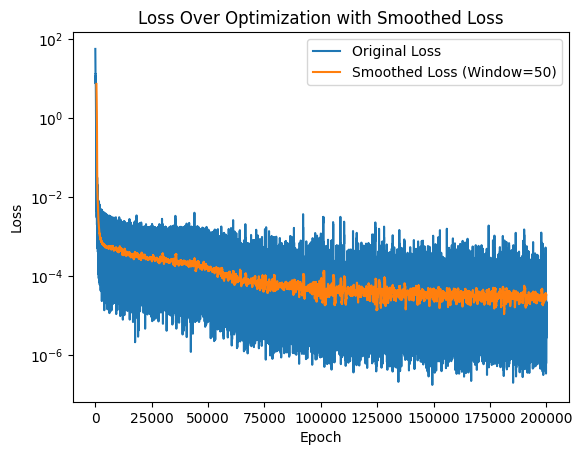

In [39]:
# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot the original losses
plt.plot(losses, label='Original Loss')

# Calculate and plot the smoothed losses
window_size = 500
smoothed_losses = moving_average(losses, window_size)
plt.plot(np.arange(window_size-1, len(losses)), smoothed_losses, label='Smoothed Loss (Window=50)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Optimization with Smoothed Loss')
plt.legend()
plt.yscale("log")
plt.show()

In [40]:
data_simulated_NN = torch.zeros(nt, len(sig_u), 2)
yi = data_simulated_NN[0, :].T
for m in range(nt - 1):
    u_m = u_data[m : m + 1, :] # torch.Size([1, 5])
    yi = simulator.step(yi, u_m)
    input = torch.cat([u_m, yi], axis=0).T  # Concatenate k and yi.T
    dy_i = solver.model(input).T # torch.Size([2, 5])
    yi = yi + dy_i
    data_simulated_NN[m + 1, :] = yi.T

In [37]:
final_error = torch.mean((data_gt -data_simulated_NN) ** 2)
final_error

tensor(1.0938e-05, grad_fn=<MeanBackward0>)

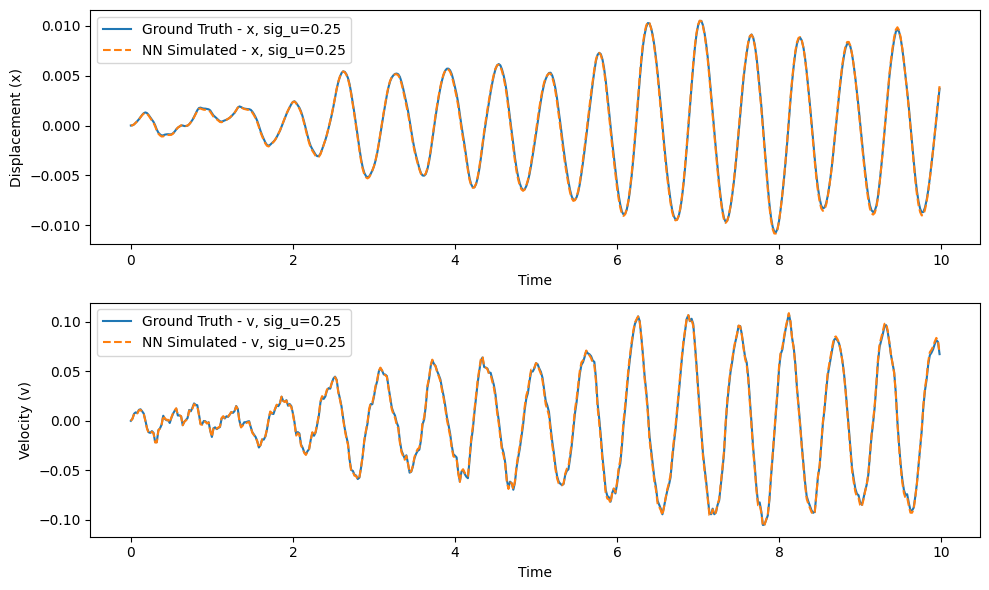

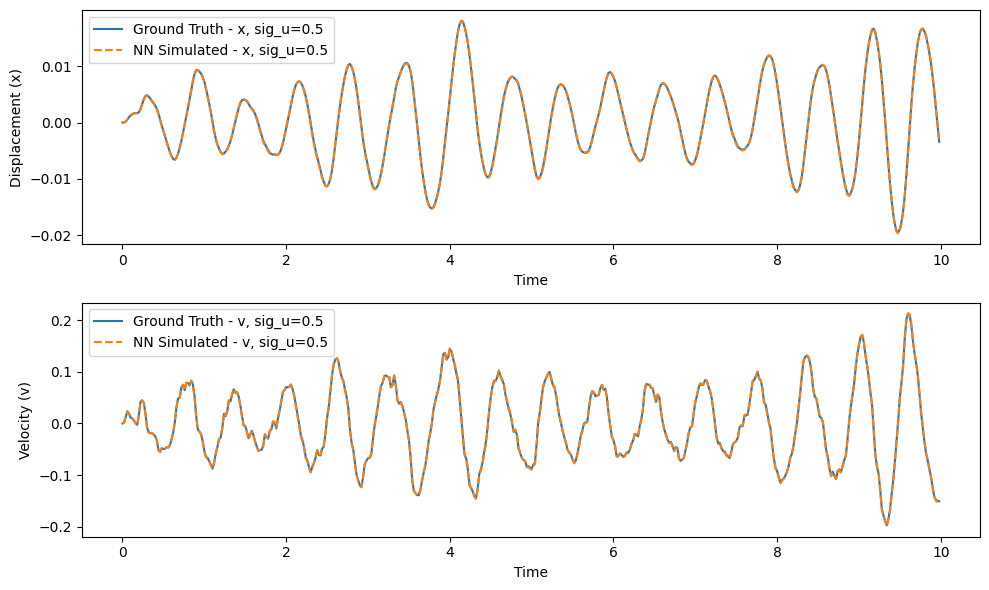

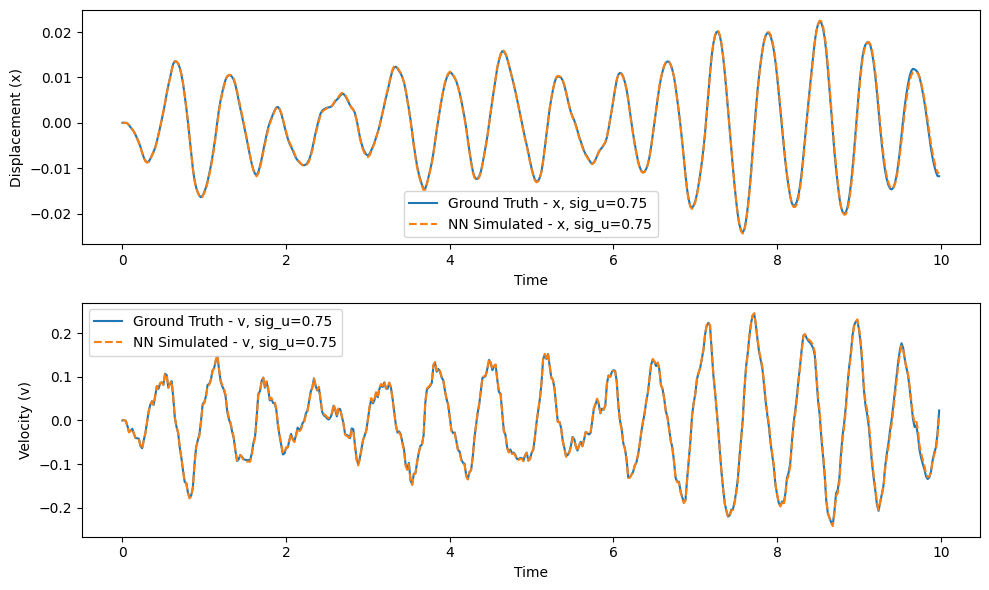

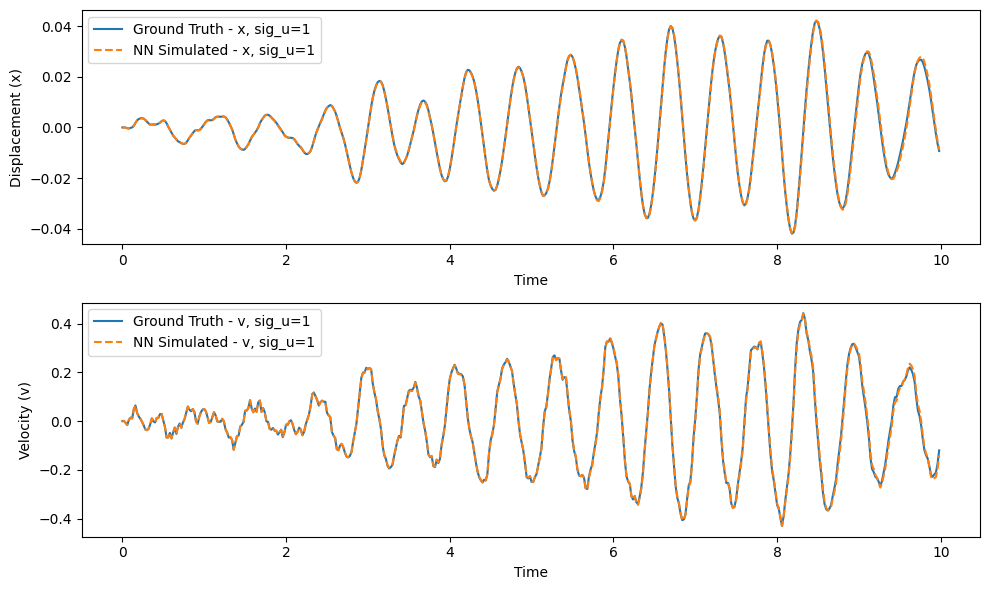

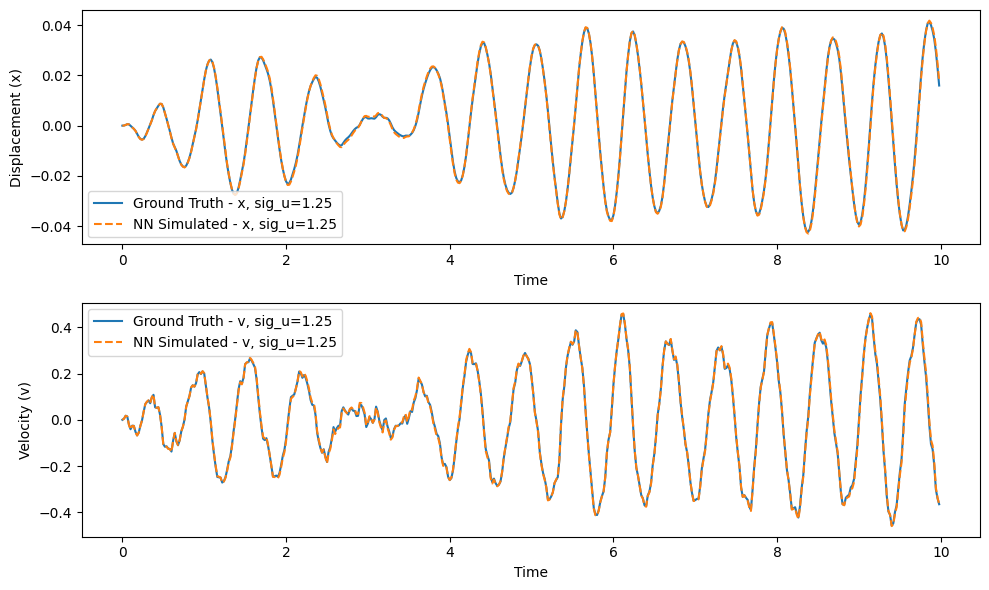

In [38]:
# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u)):
    plt.figure(figsize=(10, 6))

    # Plotting Ground Truth and Simulated Data for 'x'
    plt.subplot(2, 1, 1)
    plt.plot(time_values, data_gt[:, i, 0], label=f'Ground Truth - x, sig_u={sig_u[i]}')
    # plt.plot(time_values, data_simulated[:, i, 0], label=f'Simulated - x, sig_u={sig_u[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN.detach().numpy()[:, i, 0], label=f'NN Simulated - x, sig_u={sig_u[i]}', linestyle='dashed')

    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.legend()

    # Plotting Ground Truth and Simulated Data for 'v'
    plt.subplot(2, 1, 2)
    plt.plot(time_values, data_gt[:, i, 1], label=f'Ground Truth - v, sig_u={sig_u[i]}')
    # plt.plot(time_values, data_simulated[:, i, 1], label=f'Simulated - v, sig_u={sig_u[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN.detach().numpy()[:, i, 1], label=f'NN Simulated - v, sig_u={sig_u[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [52]:
sig_u_test = [0.1, 0.37, 0.62, 0.89, 1.11, 1.35, 1.4]
data_gt_test = torch.zeros(nt, len(sig_u_test), 2)
data_simulated_test = torch.zeros(nt, len(sig_u_test), 2)
data_simulated_NN_test = torch.zeros(nt, len(sig_u_test), 2)
u_data_test = torch.zeros(nt, len(sig_u_test))

for i in range(len(sig_u_test)):
    u = generate_u(sig_u_test[i], nt, fs, device)
    data_gt_test[:, i, :] = generate_date(spring_model_gt, u).T
    data_simulated_test[:, i, :] = generate_date(simulator, u).T
    u_data_test[:, i] = u

yi = data_simulated_NN_test[0, :].T
for m in range(nt - 1):
    u_m = u_data_test[m : m + 1, :] # torch.Size([1, 5])
    yi = simulator.step(yi, u_m)
    input = torch.cat([u_m, yi], axis=0).T  # Concatenate k and yi.T
    dy_i = solver.model(input).T # torch.Size([2, 5])
    yi = yi + dy_i
    data_simulated_NN_test[m + 1, :] = yi.T

In [53]:
initial_error_test = torch.mean((data_gt_test -data_simulated_test) ** 2)
final_error_test = torch.mean((data_gt_test -data_simulated_NN_test) ** 2)
initial_error_test, final_error_test

(tensor(0.0168), tensor(0.0008, grad_fn=<MeanBackward0>))

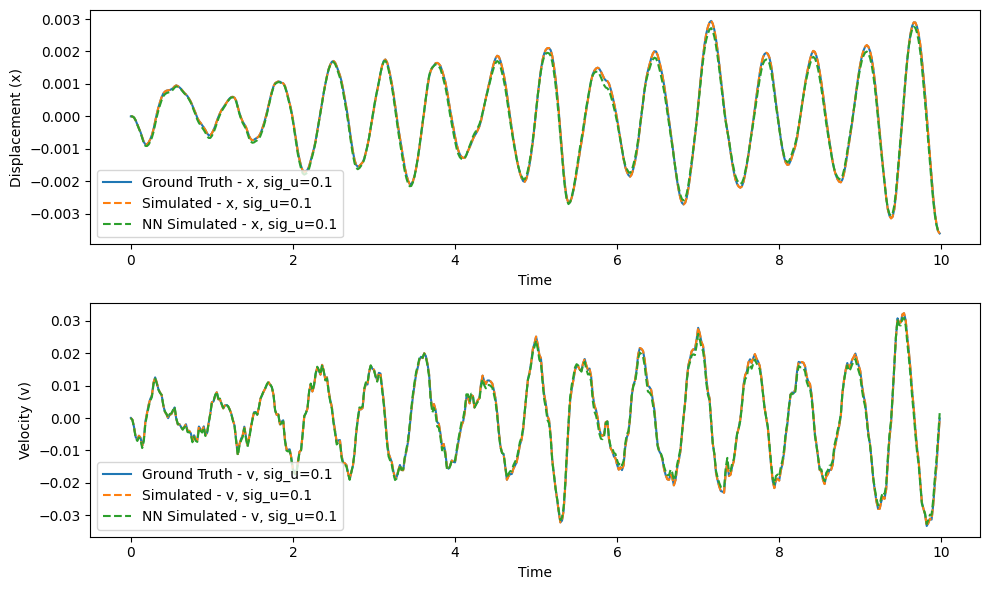

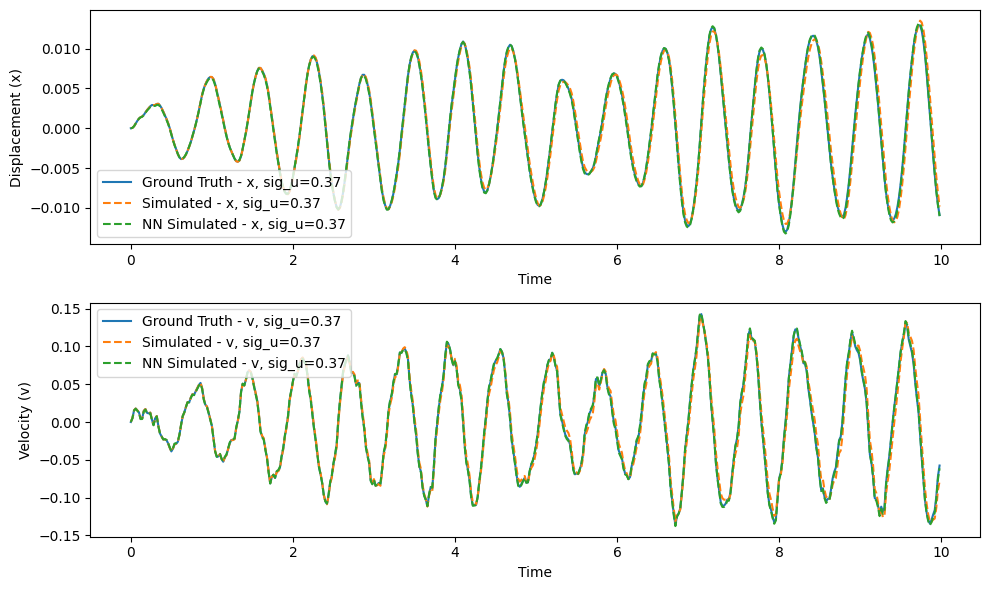

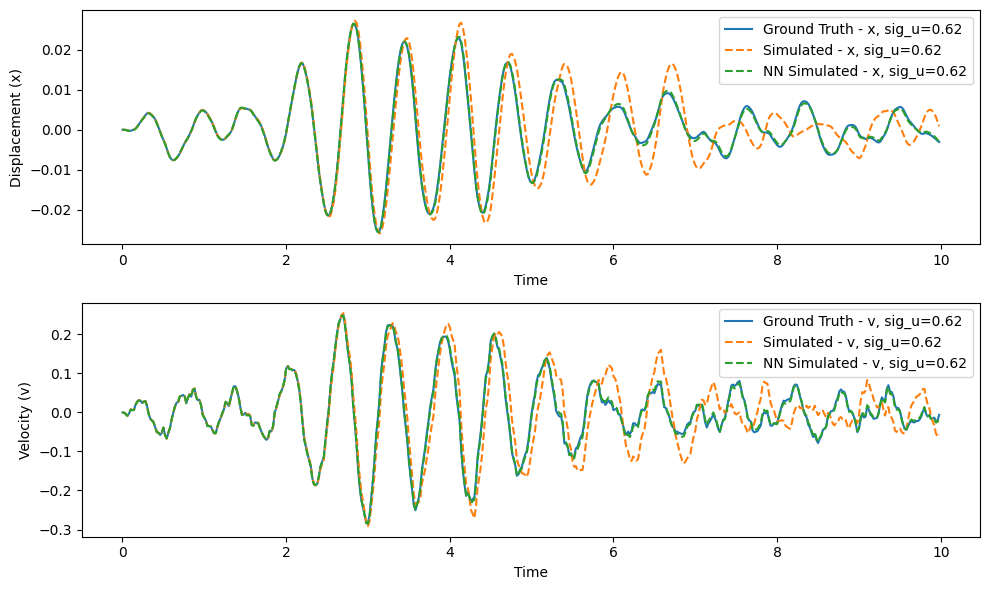

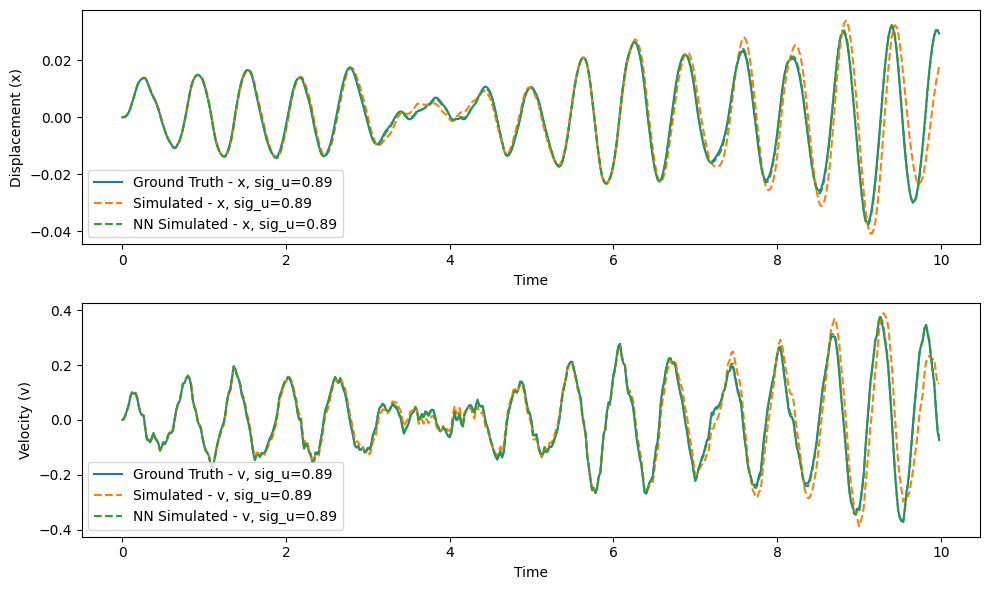

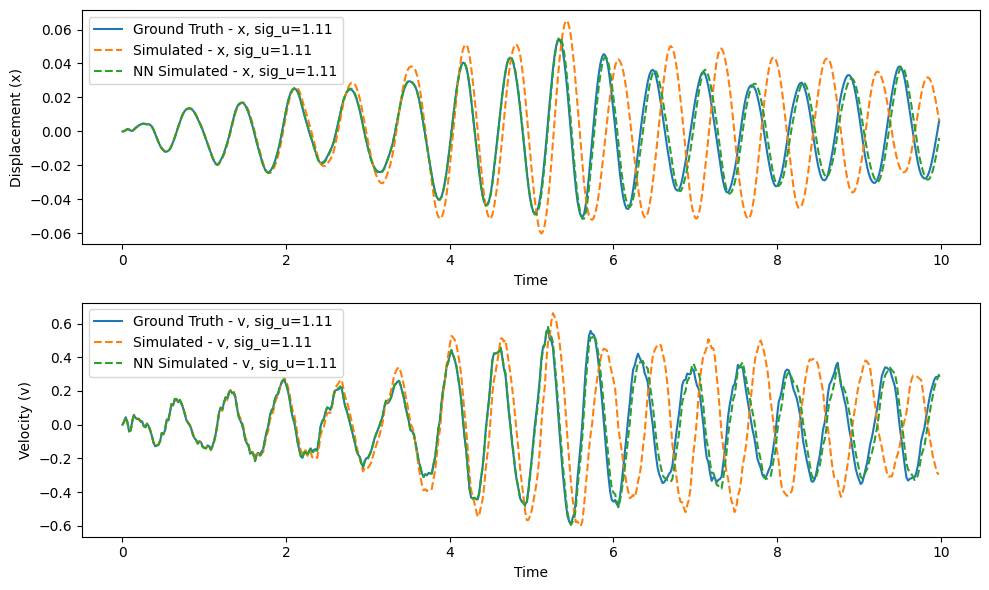

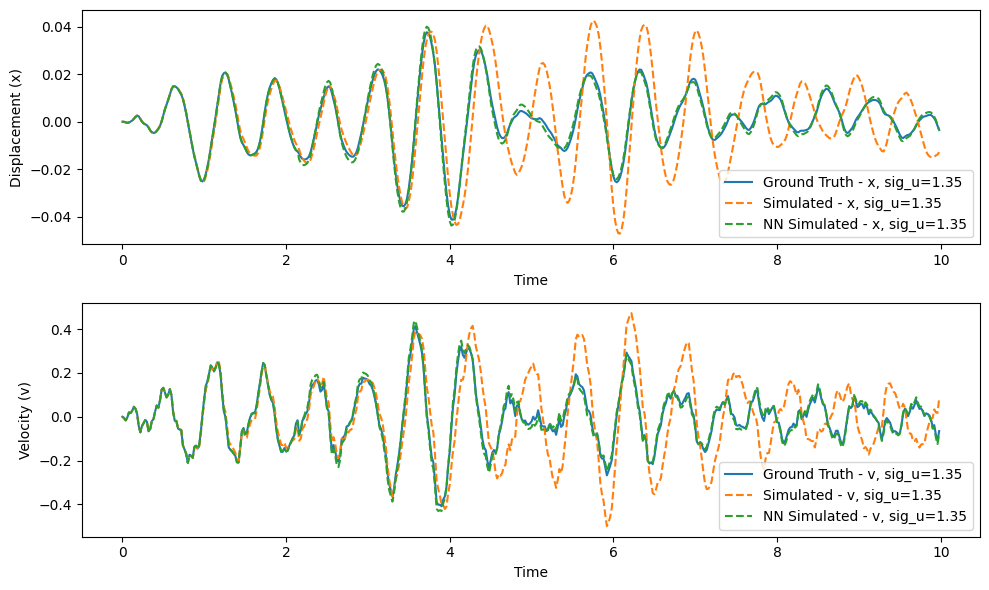

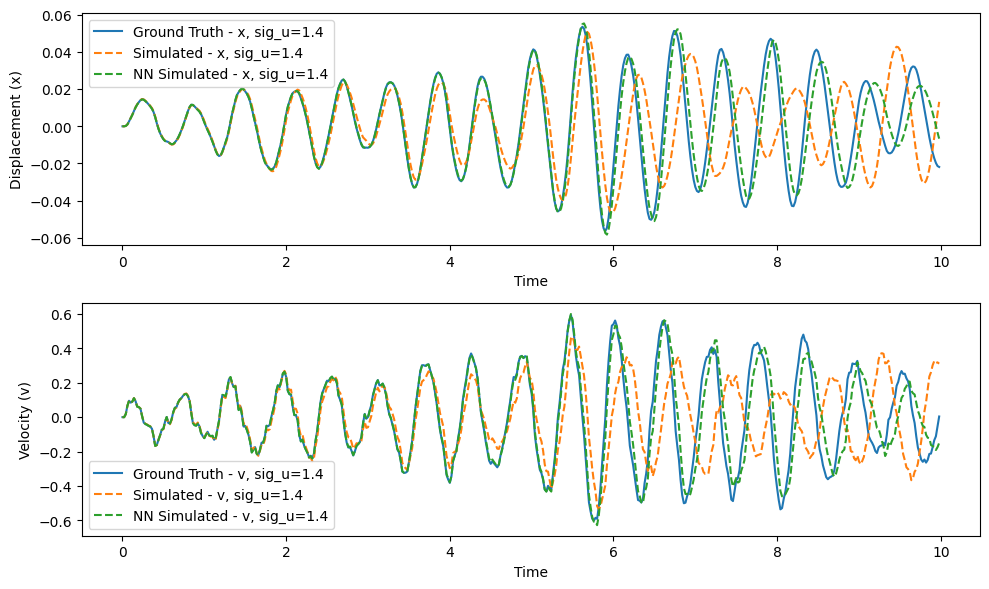

In [54]:
# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u_test)):
    plt.figure(figsize=(10, 6))

    # Plotting Ground Truth and Simulated Data for 'x'
    plt.subplot(2, 1, 1)
    plt.plot(time_values, data_gt_test[:, i, 0], label=f'Ground Truth - x, sig_u={sig_u_test[i]}')
    plt.plot(time_values, data_simulated_test[:, i, 0], label=f'Simulated - x, sig_u={sig_u_test[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, 0], label=f'NN Simulated - x, sig_u={sig_u_test[i]}', linestyle='dashed')

    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.legend()

    # Plotting Ground Truth and Simulated Data for 'v'
    plt.subplot(2, 1, 2)
    plt.plot(time_values, data_gt_test[:, i, 1], label=f'Ground Truth - v, sig_u={sig_u_test[i]}')
    plt.plot(time_values, data_simulated_test[:, i, 1], label=f'Simulated - v, sig_u={sig_u_test[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, 1], label=f'NN Simulated - v, sig_u={sig_u_test[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.legend()

    plt.tight_layout()
    plt.show()